## Feature selection of pyradiomic feutures
 #### As refered in article x the most common algoritms for feuture selection are random forest, PCA(principle component analysis) and LASSO(least absolute shrinkage and selection operator) we'll be using all 3 and choosing the one that has the best results in several metrics

library imports + dataset handling comemt further

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dataset_path = 'radiomic_features_pylidc_and_fourier.csv'  # Replace with the actual path to your CSV file
data = pd.read_csv(dataset_path)
# Get the shape of the dataset (rows, columns)
print(data.shape)

# Get basic statistics about the dataset
print(data.describe())
X = data.drop(columns=['malignancy_mode','malignancy_mean'])  # Replace 'target' with the actual column name of your labels
y = data['malignancy_mode']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


(2651, 126)
       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                      2651.000000                         2651.000000   
mean                        -36.901213                        -2031.011316   
std                          35.392737                          837.572472   
min                        -273.544294                        -3024.000000   
25%                         -44.281785                        -3024.000000   
50%                         -26.226244                        -2048.000000   
75%                         -14.955267                        -1024.000000   
max                          -0.606900                         -220.000000   

       diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
count                         2651.000000                         2651.000000   
mean                             0.506601                          767.754055   
std                              9.546720 

##### 1.1 Random forest

In [6]:
# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_rf = X_train
y_train_rf = y_train
rf.fit(X_train_rf, y_train_rf)

# Make predictions and calculate accuracy before feature selection
y_pred = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(initial_accuracy)


0.5781544256120528


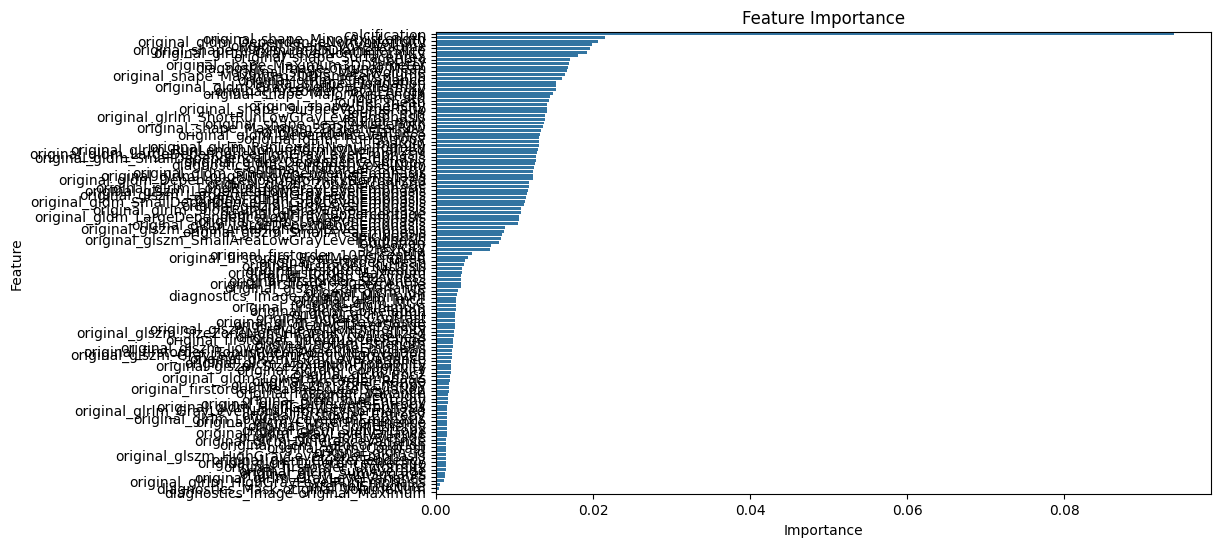

In [7]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


In [8]:
# Select top 5 features (as an example)
top_features = feature_importance_df.head(10)['Feature'].values

# Create a new dataset with only the top features
X_train_selected = X_train_rf[top_features]
X_test_selected = X_test[top_features]


# Train the classifier with selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Make predictions and calculate accuracy after feature selection
y_pred_selected = rf_selected.predict(X_test_selected)
selected_accuracy = accuracy_score(y_test, y_pred_selected)

print(f'Accuracy before feature selection: {initial_accuracy:.4f}')
print(f'Accuracy after feature selection: {selected_accuracy:.4f}')


Accuracy before feature selection: 0.5782
Accuracy after feature selection: 0.5782


#### 1.2 LASSO

In [9]:
# Convert the continuous target into binary labels (benign/malignant)
threshold = 0.5  # Assuming values >= 0.5 are malignant
y_binary = np.where(y >= threshold, 1, 0)  # 1 for malignant, 0 for benign

X_train_scaled = X_train
X_test_scaled = X_test


# Standardize the features (important for LASSO)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model with L1 (LASSO) regularization
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
lasso.fit(X_train_scaled, y_train)

# Get the coefficients
coefficients = lasso.coef_

# Find the indices of the non-zero coefficients
non_zero_features = np.where(coefficients != 0)[1]
non_zero_features = np.unique(non_zero_features)
# Print the selected features
print("Selected features:", non_zero_features)

# You can map back these indices to the original feature names if needed
selected_feature_names = X.columns[non_zero_features]
print("Selected feature names:", selected_feature_names)

Selected features: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  23  24  25  27  29  30  31  32  33  34  38  41  42  43
  44  45  48  50  51  52  53  56  57  58  61  62  63  64  65  68  70  71
  72  74  75  79  80  81  82  83  84  85  86  87  88  90  91  92  93  95
  96  97  98  99 100 101 102 103 104 105 106 107 109 110 111 112 113 114
 115 116 117 118 119 120 122]
Selected feature names: Index(['diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum', 'original_shape_Elongation',
       'original_shape_Flatness', 'original_shape_LeastAxisLength',
       'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVo

#### 1.3 PCA

In [10]:
# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA(n_components=X.shape[1])  # Fit PCA to all features
X_pca = pca.fit_transform(X_scaled)

# Step 3: Create a DataFrame with feature importance
pca_df = pd.DataFrame(pca.components_, columns=X.columns)

# Step 4: Calculate the absolute value of the feature weights
feature_importance = np.abs(pca_df).sum(axis=0)

# Step 5: Create a DataFrame to see feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 6: Print the feature importance
print("Feature Importance:")
print(feature_importance_df)

# Optional: Select top N features
N = 10  # Change this to the number of top features you want
top_features = feature_importance_df.head(N)
print(f"\nTop {N} features based on PCA:")
print(top_features)

Feature Importance:
                                                                                 Feature  \
original_glcm_DifferenceVariance                        original_glcm_DifferenceVariance   
original_glcm_Correlation                                      original_glcm_Correlation   
original_glcm_Contrast                                            original_glcm_Contrast   
original_glcm_Idmn                                                    original_glcm_Idmn   
original_glrlm_ShortRunLowGrayLevelEmphasis  original_glrlm_ShortRunLowGrayLevelEmphasis   
...                                                                                  ...   
lobulation                                                                    lobulation   
sphericity                                                                    sphericity   
calcification                                                              calcification   
fourier_min                                                 